## HW3. Stochastic Gradient Descent

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import randint

In [18]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

### Data preparation

Разобъем выборку на тренировочную и тестовую. Разбиение будем проводить сбалансированное, чтобы сохранялось процентное соотношение классов.

In [19]:
classes = ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica')

In [20]:
data = pd.read_csv('iris.data', header=None)
data.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [21]:
train, test = train_test_split(data, train_size=0.9, random_state=42, stratify=data[4])
train.shape, test.shape

((135, 5), (15, 5))

In [22]:
X_train = train[[0, 1, 2, 3]]
y_train = train[4]
X_test = test[[0, 1, 2, 3]]
y_test = test[4]

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
train_scaled = pd.DataFrame(scaler.transform(X_train))
train_scaled[4] = y_train.reset_index(drop=True)
test_scaled = pd.DataFrame(scaler.transform(X_test))
test_scaled[4] = y_test.reset_index(drop=True)

In [24]:
test_scaled

,0,1,2,3,4
0,0.937066,-0.348086,0.484926,0.124931,Iris-versicolor
1,0.328874,-1.029122,1.056673,0.255674,Iris-virginica
2,0.815428,-0.121073,0.827974,1.040127,Iris-virginica
3,-0.279318,-1.256135,0.084703,-0.136553,Iris-versicolor
4,1.788535,-0.348086,1.456896,0.778642,Iris-virginica
5,-1.738979,0.332951,-1.401839,-1.313232,Iris-setosa
6,-1.738979,-0.121073,-1.401839,-1.313232,Iris-setosa
7,-1.009148,0.786976,-1.287490,-1.313232,Iris-setosa
8,0.693789,-0.575098,1.056673,1.301611,Iris-virginica
9,0.937066,-0.121073,0.370577,0.255674,Iris-versicolor


In [25]:
train_scaled.to_csv('train.csv', header=False, index=False)
test_scaled.to_csv('test.csv', header=False, index=False)

In [26]:
train_data = pd.read_csv('train.csv', header=None)
test_data = pd.read_csv('test.csv', header=None)

### Task 1 - 3.
Обучите модель логистической регресси с помощью SGD и batch gradient descent. Подберите нужные параметры по сетке. Сравните полученные решения.

Напишем свой класс-классификатор.

In [27]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [28]:
class GDClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, type_='stochastic', learning_rate=0.01, n_iter=1000, alpha=0.01):
        self.type_ = type_
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.alpha = alpha

        self.weights = None
        self.coeffs_ = None

    @staticmethod
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def compute_gradient(x, y, w):
        grad = np.dot(x.T, GDClassifier.sigmoid(x.dot(w)) - y)
        return grad if len(x.shape) == 1 else grad / len(x)

    def fit(self, X_train, y_train):
        x, y = X_train, y_train
        n_obs = x.shape[0]
        n_features = x.shape[1]

        self.weights = np.zeros((self.n_iter, n_features))

        for k in range(self.n_iter - 1):
            if self.type_ == 'stochastic':
                ind = randint(0, n_obs - 1)
                x, y = X_train[ind, :], y_train[ind]

            w = self.weights[k]
            grad = self.compute_gradient(x, y, w) + self.alpha*w

            u = -self.learning_rate*grad
            self.weights[k+1] = self.weights[k] + u

        self.coeffs_ = self.weights.mean(axis=0)
        return self

    def predict(self, X):
        return self.sigmoid(X.dot(self.coeffs_)) >= 0.5

Подготовим данные: выберем константный столбец и выделим наш целевой класс в данных.

In [29]:
def prepare_data(X, y, class_name):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    y = (y == class_name)
    return X.astype(float), np.array(y)

Зададим данные для перебора.

In [30]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
    'n_iter': [100, 200, 500, 750, 1000, 2500, 5000],
    'alpha': [0.01, 0.001, 0.0001, 0.0]
}

Проведем эксперименты.

In [31]:
for type_ in ['batch', 'stochastic']:
    for cls in classes:
        print('***** ***** ***** *****')
        print(f'Target class: {cls}')
        print(f'Method: {type_}')

        X_train, y_train = prepare_data(train_data[[0, 1, 2, 3]], train_data[4], cls)
        X_test, y_test = prepare_data(test_data[[0, 1, 2, 3]], test_data[4], cls)

        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        clf = GridSearchCV(GDClassifier(type_=type_), param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kf)
        clf.fit(X_train, y_train)

        print(f'Best classifier: {clf.best_estimator_}')
        print(f'Best CV score: {clf.best_score_:.4}')
        print(f'Test score: {accuracy_score(y_test, clf.predict(X_test)):.4}')
        print('***** ***** ***** *****')
        print()

***** ***** ***** *****
Target class: Iris-setosa
Method: batch
Best classifier: GDClassifier(alpha=0.01, learning_rate=0.1, n_iter=100, type_='batch')
Best CV score: 1.0
Test score: 1.0
***** ***** ***** *****

***** ***** ***** *****
Target class: Iris-versicolor
Method: batch
Best classifier: GDClassifier(alpha=0.001, learning_rate=0.1, n_iter=5000, type_='batch')
Best CV score: 0.7333
Test score: 0.6
***** ***** ***** *****

***** ***** ***** *****
Target class: Iris-virginica
Method: batch
Best classifier: GDClassifier(alpha=0.001, learning_rate=0.1, n_iter=2500, type_='batch')
Best CV score: 0.963
Test score: 0.8667
***** ***** ***** *****

***** ***** ***** *****
Target class: Iris-setosa
Method: stochastic
Best classifier: GDClassifier(alpha=0.01, learning_rate=0.1, n_iter=100, type_='stochastic')
Best CV score: 1.0
Test score: 1.0
***** ***** ***** *****

***** ***** ***** *****
Target class: Iris-versicolor
Method: stochastic
Best classifier: GDClassifier(alpha=0.0001, learni

Из полученных результатов можно видеть, что хорошо отделимый класс "Iris-setosa" классифицируется обоими алгоритмами за наименьшее количество итераций. И на кросс-валидации, и на тестовой выборке алгоритм не ошибся.

Для класса "Iris-versicolor" результаты не такие радостные. Алгоритму потребовалось больше итераций, чтобы сойтись. При этом SGD справился с задачей за меньшее количество итераций чем BGD.

Класс "Iris-virginica" алгоритм распознает достаточно хорошо, что видно по результатам и на кросс-валидации, и на тестовой выборке. 



Обобщив, получим, что и на кросс-валидации, и на тестовой выборке SGD показал немного лучше результаты, чем BGD на всех классах ирисов. Результаты работы обоих алгоритмов сопоставимы.

Преимущества SGD:
    Требует меньших вычислительных затрат, так как работает только с одним объектом за итерацию.

Недостатки SGD:
    Может застрять в локальном минимуме.

Преимущества BGD:
    Стабильная сходимость.

Недостатки BGD:
    Требует больших вычислительных затрат, так как оперирует всей выборкой.

### Task 4

Внесем изменения в класс, чтобы поддерживались оптимизаторы.

In [66]:
class GDClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, type_='stochastic', learning_rate=0.01, n_iter=1000, alpha=0.01,
                 optimization=None, beta=0.9, gamma=0.9, eps=1.0e-9):
        self.type_ = type_
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.alpha = alpha

        self.weights = None
        self.coeffs_ = None

        # add optimization
        self.optimization = optimization
        self.beta = beta
        self.gamma = gamma
        self.eps = eps

        self.func_router = {
            'adam': self.adam,
            'rmsprop': self.rmsprop,
            'adagrad': self.adagrad,
            'momentum': self.momentum,
            'nesterov_momentum': self.nesterov_momentum
        }

    @staticmethod
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def compute_gradient(x, y, w):
        grad = np.dot(x.T, GDClassifier.sigmoid(x.dot(w)) - y)
        return grad if len(x.shape) == 1 else grad / len(x)

    def fit(self, X_train, y_train):
        x, y = X_train, y_train
        n_obs = x.shape[0]
        n_features = x.shape[1]

        self.weights = np.zeros((self.n_iter, n_features))
        u = np.zeros_like(self.weights[0])

        for k in range(self.n_iter - 1):
            if self.type_ == 'stochastic':
                ind = randint(0, n_obs - 1)
                x, y = X_train[ind, :], y_train[ind]

            w = self.weights[k]

            try:
                u = self.func_router[self.optimization](x, y, u, w)
            except:
                raise Exception('Unknown optimization.')

            self.weights[k+1] = self.weights[k] + u

        self.coeffs_ = self.weights.mean(axis=0)
        return self

    def predict(self, X):
        return self.sigmoid(X.dot(self.coeffs_)) >= 0.5

    def adam(self, x, y, u, w):
        m = np.zeros_like(self.weights[0])
        v = np.zeros_like(self.weights[0])

        grad = self.compute_gradient(x, y, w) + self.alpha * w
        m = self.gamma * m + (1 - self.gamma) * grad
        v = self.beta * v + (1 - self.beta) * (grad ** 2)
        return - self.learning_rate * m / (np.sqrt(v) + self.eps)

    def rmsprop(self, x, y, u, w):
        g = np.zeros_like(self.weights[0])

        grad = self.compute_gradient(x, y, w) + self.alpha * w
        g = self.beta * g + (1 - self.beta) * (grad ** 2)
        return -self.learning_rate * grad / (np.sqrt(g + self.eps))

    def adagrad(self, x, y, u, w):
        g = np.zeros_like(self.weights[0])

        grad = self.compute_gradient(x, y, w) + self.alpha * w
        g += grad ** 2
        return -self.learning_rate * grad / (np.sqrt(g) + self.eps)

    def momentum(self, x, y, u, w):
        grad = self.compute_gradient(x, y, w) + self.alpha * w
        return self.gamma * u - self.learning_rate * grad

    def nesterov_momentum(self, x, y, u, w):
        w += self.gamma * u
        grad = self.compute_gradient(x, y, w) + self.alpha * w
        return self.gamma * u - self.learning_rate * grad


In [33]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
    'n_iter': [100, 250, 500, 1000, 1500],
    'alpha': [0.01, 0.001, 0.0001, 0.0],
    'beta': [0.9, 0.99, 0.999],
    'gamma': [0.9, 0.99, 0.999]
}

In [63]:
optimizer = [
    {'type_': 'batch', 'optimization': 'adam'},
    {'type_': 'batch', 'optimization': 'rmsprop'},
    {'type_': 'batch', 'optimization': 'adagrad'},
    {'type_': 'stochastic', 'optimization': 'momentum'},
    {'type_': 'stochastic', 'optimization': 'nesterov_momentum'},
]

best_estimators = {}

for cls in classes:
    X_train, y_train = prepare_data(train_data[[0, 1, 2, 3]], train_data[4], cls)
    X_test, y_test = prepare_data(test_data[[0, 1, 2, 3]], test_data[4], cls)

    for opt in optimizer:
        print('***** ***** ***** *****')
        print(f'Target class: {cls}')
        print(f'Optimizer: {opt}')

        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        clf = GridSearchCV(GDClassifier(**opt), param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kf)
        clf.fit(X_train, y_train)

        print(f'Best classifier: {clf.best_estimator_}')
        print(f'Best CV score: {clf.best_score_:.4}')
        print(f'Test score: {accuracy_score(y_test, clf.predict(X_test)):.4}')
        print('***** ***** ***** *****')
        print()

        # clf.best_estimator_.plot_iterations(1500, X_train, y_train, X_test, y_test)
        
        best_estimators.setdefault(cls, []).append(clf.best_estimator_)

***** ***** ***** *****
Target class: Iris-setosa
Optimizer: {'type_': 'batch', 'optimization': 'adam'}
Best classifier: GDClassifier(alpha=0.01, beta=0.9, eps=1e-09, gamma=0.9, learning_rate=0.1,
             n_iter=100, optimization='adam', type_='batch')
Best CV score: 1.0
Test score: 1.0
***** ***** ***** *****

***** ***** ***** *****
Target class: Iris-setosa
Optimizer: {'type_': 'batch', 'optimization': 'rmsprop'}
Best classifier: GDClassifier(alpha=0.01, beta=0.9, eps=1e-09, gamma=0.9, learning_rate=0.1,
             n_iter=100, optimization='rmsprop', type_='batch')
Best CV score: 1.0
Test score: 1.0
***** ***** ***** *****

***** ***** ***** *****
Target class: Iris-setosa
Optimizer: {'type_': 'batch', 'optimization': 'adagrad'}
Best classifier: GDClassifier(alpha=0.01, beta=0.9, eps=1e-09, gamma=0.9, learning_rate=0.1,
             n_iter=100, optimization='adagrad', type_='batch')
Best CV score: 1.0
Test score: 1.0
***** ***** ***** *****

***** ***** ***** *****
Target cla

In [79]:
def plot_iterations(clf, max_iterations, X_train, y_train, X_test, y_test):
    clf.n_iter = max_iterations
    clf.fit(X_train, y_train)

    accuracies = [accuracy_score(y_test, clf.sigmoid(X_test.dot(clf.weights[:i+1].mean(axis=0))) >= 0.5)
                  for i in range(max_iterations)]

    plt.plot(range(max_iterations), accuracies)

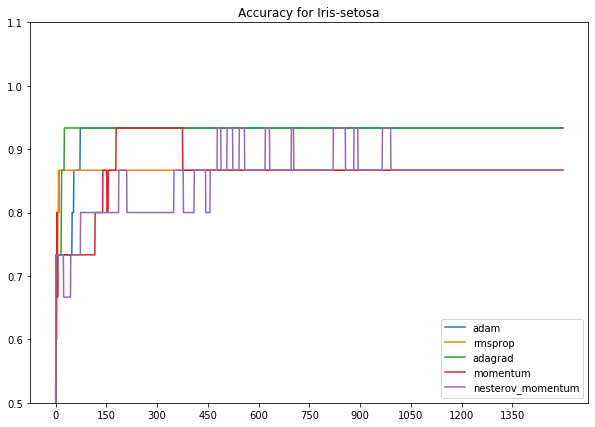

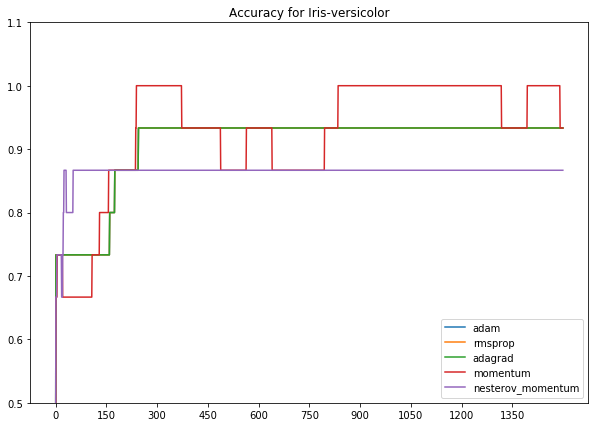

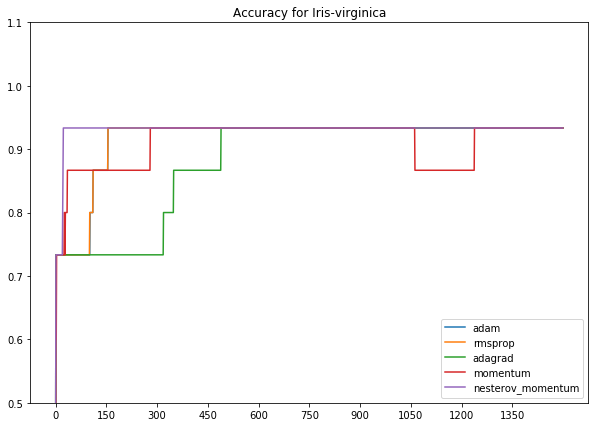

In [80]:
max_iter = 1500
for cls in classes:
    plt.figure(figsize=(10, 7))
    for clf in best_estimators[cls]:
        plot_iterations(clf, 1500, X_train, y_train, X_test, y_test)
    
    plt.ylim(0.5, 1.1)
    plt.xticks(range(0, max_iter, 150))
    plt.legend(['adam', 'rmsprop', 'adagrad', 'momentum', 'nesterov_momentum'], loc='lower right')
    plt.title(f'Accuracy for {cls}')
    plt.show()

По полученным результатм видно, что оптимизация "nesterov-momentum" показала хорошие результаты на обоих выборках. при этом в случае с "Iris-verticolor" и "Iris-virginica" - быструю сходимость.